In [1]:
import confirm.outlaw.nb_util as nb_util

nb_util.setup_nb()
import jax
import numpy as np
import matplotlib.pyplot as plt
from confirm.lewislib import lewis
import confirm.imprint as ip

In [2]:
name = "1d_slice"
params = {
    "n_arms": 4,
    "n_stage_1": 50,
    "n_stage_2": 100,
    "n_stage_1_interims": 2,
    "n_stage_1_add_per_interim": 100,
    "n_stage_2_add_per_interim": 100,
    "stage_1_futility_threshold": 0.15,
    "stage_1_efficacy_threshold": 0.7,
    "stage_2_futility_threshold": 0.2,
    "stage_2_efficacy_threshold": 0.95,
    "inter_stage_futility_threshold": 0.6,
    "posterior_difference_threshold": 0,
    "rejection_threshold": 0.05,
    "key": jax.random.PRNGKey(0),
    "n_table_pts": 20,
    "n_pr_sims": 100,
    "n_sig2_sims": 20,
    "batch_size": int(2**12),
    "cache_tables": f"./{name}/lei_cache.pkl",
}

In [3]:
g = ip.cartesian_grid([-1, -10], [1, -1], n=[10, 10]).add_null_hypos(
    [ip.hypo("theta0 > theta1")]
)

In [4]:
db = ip.db.DuckDB.connect("lewis1dslice.db")

In [5]:
def T(theta_in, radii_in, null_truth_in):
    theta_out = np.empty((theta_in.shape[0], 4))
    theta_out[:, 0] = theta_in[:, 0]
    theta_out[:, 1] = theta_in[:, 0]
    theta_out[:, 2] = theta_in[:, 0]
    theta_out[:, 3] = theta_in[:, 1]
    radii_out = np.empty((theta_in.shape[0], 4))
    radii_out[:, 0] = radii_in[:, 0]
    radii_out[:, 1] = radii_in[:, 0]
    radii_out[:, 2] = radii_in[:, 0]
    radii_out[:, 3] = radii_in[:, 1]
    null_truth_out = np.empty((theta_in.shape[0], 3))
    null_truth_out[:, 0] = null_truth_in[:, 0]
    null_truth_out[:, 1] = null_truth_in[:, 0]
    null_truth_out[:, 2] = null_truth_in[:, 0]
    return theta_out, radii_out, null_truth_out


ada_iter, reports, db = ip.ada_validate(
    lewis.Lewis45Model,
    g=g,
    db=db,
    lam=0.06253,
    n_iter=100,
    iter_size=2**13,
    init_K=2**16,
    n_K_double=3,
    global_target=0.003,
    max_target=0.003,
    transformation=T,
    model_kwargs=params,
)

{'i': 1,
 'max_grid_cost': nan,
 'max_sim_cost': nan,
 'max_total_cost': nan,
 'n_work': 0,
 'runtime_convergence_check': 2.0313143730163574,
 'worst_tile_bound': 0.004215397047330215,
 'worst_tile_cost': 0.0019418374770177153,
 'worst_tile_est': 0.0022735595703125}


In [6]:
ga = ip.Grid(db.get_all()).active()

In [7]:
tc = np.linspace(-1, 1, 99)
t3 = np.linspace(-10, -1, 100)
TT = np.stack(np.meshgrid(tc, t3, indexing="ij"), axis=-1)
TT.shape

(99, 100, 2)

In [8]:
import scipy.interpolate

interp_bound = scipy.interpolate.griddata(
    ga.get_theta(), ga.df["tie_bound"], TT.reshape(-1, 2)
)

In [9]:
interp_est = scipy.interpolate.griddata(
    ga.get_theta(), ga.df["tie_est"], TT.reshape(-1, 2)
)

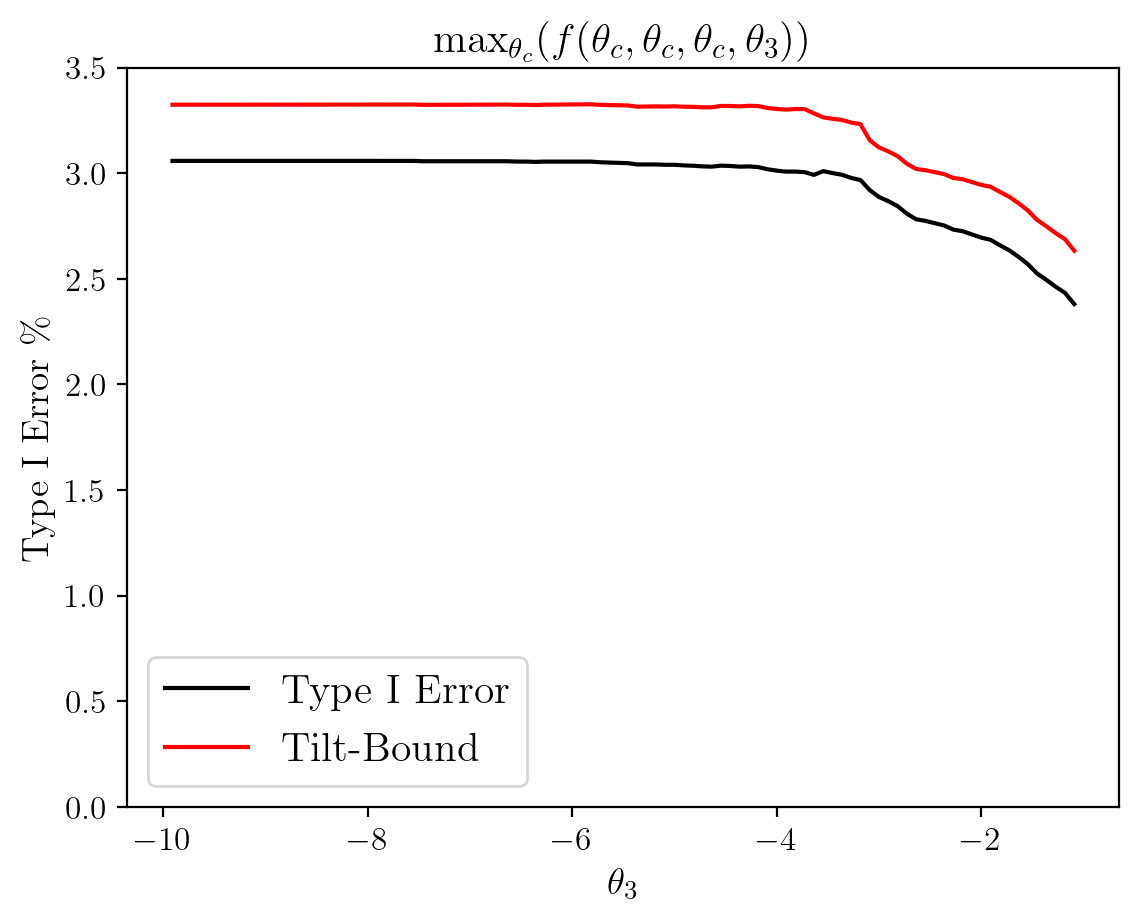

In [10]:
plt.plot(
    t3[1:-1],
    100 * interp_est.reshape(99, 100)[1:-1, 1:-1].max(axis=0),
    "k-",
    label="Type I Error",
)
plt.plot(
    t3[1:-1],
    100 * interp_bound.reshape(99, 100)[1:-1, 1:-1].max(axis=0),
    "r-",
    label="Tilt-Bound",
)
plt.legend()
plt.ylim([0, 3.5])
plt.xlabel(r"$\theta_{3}$")
plt.ylabel(r"Type I Error \%")
plt.title(r"$\max_{\theta_c}(f(\theta_c, \theta_c, \theta_c, \theta_3))$")
plt.savefig("lewis_1d_orthogonal.pdf", bbox_inches="tight")
plt.show()

## old stuff

In [44]:
import os
import time
import modal
import pandas as pd
import confirm.cloud.modal_util as modal_util

stub = modal.Stub("confirm")

img = modal_util.get_image()


@stub.function(
    image=img,
    gpu=modal.gpu.A100(),
    retries=0,
    mounts=modal.create_package_mounts(["confirm"]),
    timeout=60 * 60 * 2,
)
def cloud_validate(g, *, K, params):
    start = time.time()
    rej_df = ip.validate(
        lewis.Lewis45Model,
        g,
        lam=0.06253,
        K=K,
        tile_batch_size=128,
        model_kwargs=params,
    )
    print(time.time() - start)
    return g.add_cols(rej_df)

In [45]:
g = ip.cartesian_grid([-1, -2], [1, -1], n=[10, 400]).concat(
    ip.cartesian_grid([-1, -4], [1, -2], n=[10, 400]),
    ip.cartesian_grid([-1, -8], [1, -4], n=[10, 400]),
    ip.cartesian_grid([-1, -10], [1, -8], n=[10, 100]),
)
g.df["theta3"] = g.df["theta1"]
g.df["theta1"] = g.df["theta0"]
g.df["theta2"] = g.df["theta0"]
g.df["radii3"] = g.df["radii1"]
g.df["radii0"] = 0
g.df["radii1"] = 0
g.df["radii2"] = 0
g.df["null_truth0"] = True
g.df["null_truth1"] = True
g.df["null_truth2"] = True

In [46]:
g.df.shape

(13000, 15)

In [5]:
# import pandas as pd
# rej_df = pd.read_parquet("./1d_slice/1d_orthogonal_ada.parquet")
# rej_df
# boundcost = rej_df['tie_bound'] - rej_df['tie_cp_bound']
# refine = boundcost > 0.001
# g_refine = g.subset(refine).refine()
# g_new = g_refine.concat(g.subset(~refine))
# new_t3 = np.sort(np.unique(g_new.df['theta3']))
# new_t3.shape[0]
# plt.plot(new_t3, '*')
# plt.show()

In [12]:
n_chunks = 50
with stub.run():
    i = 27
    gs = [ip.grid.Grid(d, g.null_hypos) for d in np.array_split(g.df, n_chunks)][i:]
    rej_gs = []
    for rej_g in cloud_validate.map(
        gs, kwargs={"K": int(1.5 * 2**19), "params": params}, order_outputs=True
    ):
        rej_g.df.to_parquet(f"./1d_slice/chunk_{i}.parquet")
        i += 1
        rej_gs.append(rej_g)

Output()

✓ Initialized. View app at https://modal.com/apps/ap-PBgJxQO27hBdpLqbECUUpo

Output()

✓ Created objects.
├── 🔨 Created cloud_validate.
└── 🔨 Mounted /Users/tbent/confirm/confirmasaurus/confirm at /pkg/confirm

Output()

148.8567566871643


149.31953930854797


149.0628068447113


149.45700407028198


150.09921622276306


150.49510192871094


151.2924509048462


151.65242505073547


152.3472957611084


117.488938331604


120.01974129676819


120.48123025894165


120.84148049354553


119.5331859588623


121.00506472587585


119.574298620224


120.39628434181213


121.26166725158691


118.70394277572632


118.51146793365479


119.58072662353516


119.8971529006958


120.42080640792847


✓ App completed.

In [50]:
rej_gs = []
for i in range(n_chunks):
    chunk_g = pd.read_parquet(f"./1d_slice/chunk_{i}.parquet")
    n_rows = chunk_g.shape[0]
    if i > 0:
        rej_gs.append(
            pd.concat(
                (
                    chunk_g.iloc[: n_rows // 2]
                    .reset_index()
                    .drop(["tie_sum", "tie_est", "tie_cp_bound", "tie_bound"], axis=1),
                    chunk_g.iloc[n_rows // 2 :][
                        ["tie_sum", "tie_est", "tie_cp_bound", "tie_bound"]
                    ].reset_index(),
                ),
                axis=1,
            ).drop("index", axis=1)
        )
    else:
        rej_gs.append(chunk_g)
rej_g_final = ip.grid.Grid(rej_gs[0]).concat(*[ip.grid.Grid(g) for g in rej_gs[1:]])
rej_g_final.df.to_parquet("./1d_slice/1d_orthogonal_chunks.parquet")

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_7536/3011929630.py:6: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  rej_gs.append(pd.concat(
/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_7536/3011929630.py:6: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  rej_gs.append(pd.concat(
/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_7536/3011929630.py:6: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  rej_gs.append(pd.concat(
/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_7536/3011929630.py:6: FutureWarning: In a future version, object-dtype columns with all-bool value

In [52]:
import pandas as pd

rej_df = pd.read_parquet("./1d_slice/1d_orthogonal_chunks.parquet")
rej_df

,id,active,eligible,parent_id,theta0,theta1,radii0,radii1,theta3,theta2,radii3,radii2,null_truth0,null_truth1,null_truth2,tie_sum,tie_est,tie_cp_bound,tie_bound
0,1.025139e+19,True,True,0.0,-0.9,-0.9,0.0,0.0,-1.99875,-0.9,0.00125,0.0,True,True,True,11270.0,0.014331,0.014645,0.014990
1,1.025139e+19,True,True,0.0,-0.7,-0.7,0.0,0.0,-1.99875,-0.7,0.00125,0.0,True,True,True,15135.0,0.019245,0.019609,0.020053
2,1.025139e+19,True,True,0.0,-0.5,-0.5,0.0,0.0,-1.99875,-0.5,0.00125,0.0,True,True,True,18254.0,0.023211,0.023609,0.024131
3,1.025139e+19,True,True,0.0,-0.3,-0.3,0.0,0.0,-1.99875,-0.3,0.00125,0.0,True,True,True,20007.0,0.025440,0.025856,0.026420
4,1.025139e+19,True,True,0.0,-0.1,-0.1,0.0,0.0,-1.99875,-0.1,0.00125,0.0,True,True,True,21067.0,0.026788,0.027215,0.027803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12995,1.025139e+19,True,True,0.0,0.1,0.1,0.0,0.0,-8.01000,0.1,0.01000,0.0,True,True,True,22662.0,0.028816,0.029258,0.029785
12996,1.025139e+19,True,True,0.0,0.3,0.3,0.0,0.0,-8.01000,0.3,0.01000,0.0,True,True,True,22456.0,0.028554,0.028994,0.029517
12997,1.025139e+19,True,True,0.0,0.5,0.5,0.0,0.0,-8.01000,0.5,0.01000,0.0,True,True,True,21216.0,0.026978,0.027406,0.027905
12998,1.025139e+19,True,True,0.0,0.7,0.7,0.0,0.0,-8.01000,0.7,0.01000,0.0,True,True,True,19156.0,0.024358,0.024766,0.025226


In [63]:
worst_bound = rej_df.loc[rej_df.reset_index().groupby(["theta3"])["tie_bound"].idxmax()]
worst_bound

,id,active,eligible,parent_id,theta0,theta1,radii0,radii1,theta3,theta2,radii3,radii2,null_truth0,null_truth1,null_truth2,tie_sum,tie_est,tie_cp_bound,tie_bound
12001,1.025139e+19,True,True,0.0,-0.7,-0.7,0.0,0.0,-9.99000,-0.7,0.01000,0.0,True,True,True,24396.0,0.031021,0.031479,0.031814
12011,1.025139e+19,True,True,0.0,-0.7,-0.7,0.0,0.0,-9.97000,-0.7,0.01000,0.0,True,True,True,24396.0,0.031021,0.031479,0.031815
12021,1.025139e+19,True,True,0.0,-0.7,-0.7,0.0,0.0,-9.95000,-0.7,0.01000,0.0,True,True,True,24396.0,0.031021,0.031479,0.031817
12031,1.025139e+19,True,True,0.0,-0.7,-0.7,0.0,0.0,-9.93000,-0.7,0.01000,0.0,True,True,True,24396.0,0.031021,0.031479,0.031818
12041,1.025139e+19,True,True,0.0,-0.7,-0.7,0.0,0.0,-9.91000,-0.7,0.01000,0.0,True,True,True,24396.0,0.031021,0.031479,0.031820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3957,1.025139e+19,True,True,0.0,0.5,0.5,0.0,0.0,-1.01125,0.5,0.00125,0.0,True,True,True,17866.0,0.022718,0.023112,0.023792
3967,1.025139e+19,True,True,0.0,0.5,0.5,0.0,0.0,-1.00875,0.5,0.00125,0.0,True,True,True,17855.0,0.022704,0.023098,0.023778
3977,1.025139e+19,True,True,0.0,0.5,0.5,0.0,0.0,-1.00625,0.5,0.00125,0.0,True,True,True,17836.0,0.022680,0.023073,0.023753
3987,1.025139e+19,True,True,0.0,0.5,0.5,0.0,0.0,-1.00375,0.5,0.00125,0.0,True,True,True,17833.0,0.022676,0.023069,0.023750


In [ ]:
plt.scatter(rej_df[""])

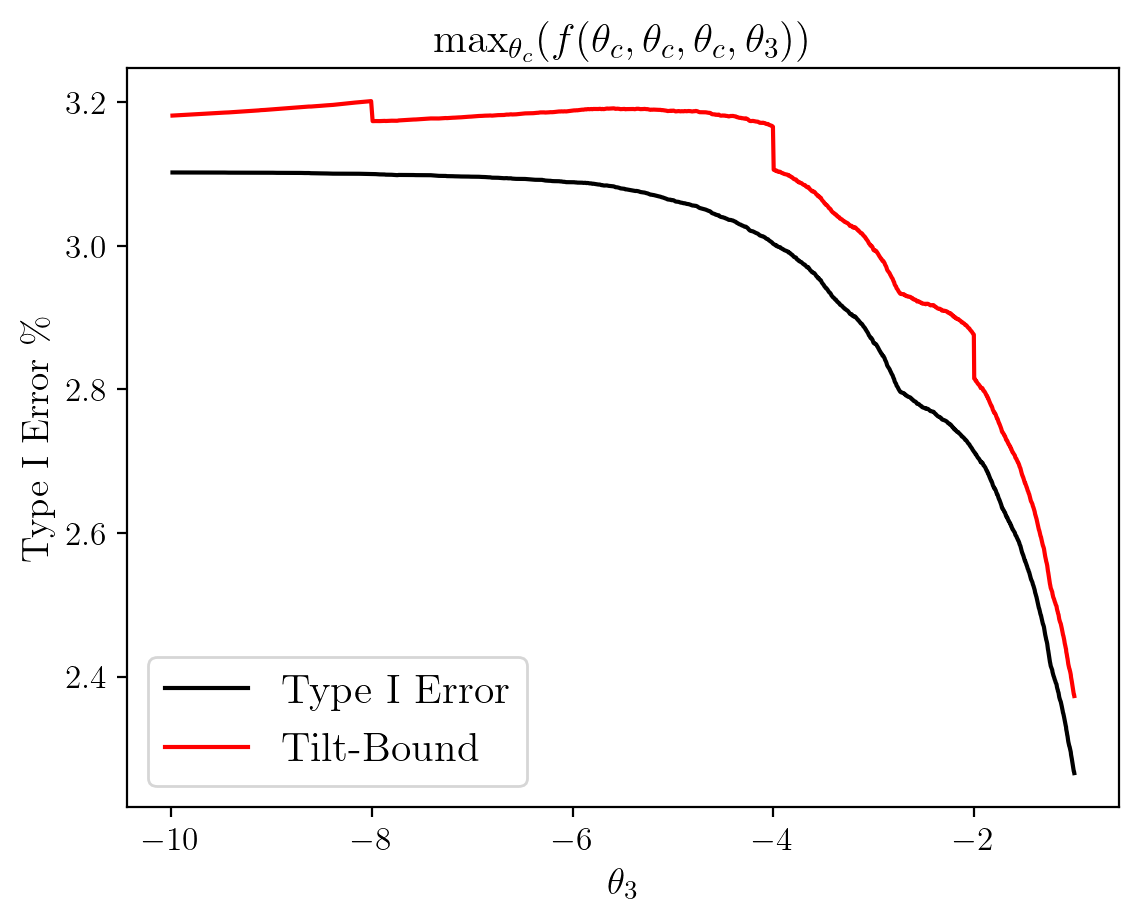

In [64]:
# worst_tie = rej_df["tie_est"].values.reshape((100, 20)).max(axis=1)
# worst_bound = rej_df["tie_bound"].values.reshape((100, 20)).max(axis=1)
plt.plot(
    worst_bound["theta3"],
    100 * worst_bound["tie_est"],
    "k-",
    label="Type I Error",
)
plt.plot(
    worst_bound["theta3"],
    100 * worst_bound["tie_bound"],
    "r-",
    label="Tilt-Bound",
)
plt.legend()
plt.xlabel(r"$\theta_{3}$")
plt.ylabel(r"Type I Error \%")
plt.title(r"$\max_{\theta_c}(f(\theta_c, \theta_c, \theta_c, \theta_3))$")
plt.savefig("lewis_1d_orthogonal.pdf", bbox_inches="tight")
plt.show()